# **Consumer Analytical Profile Analysis (LDP) 1 Month Interactions**

In [1]:
%run bi_feature_eng_utilities.ipynb 
!pip install pyarrow
!pip install dask
#Clean up previous tables
!aws s3 rm --recursive s3://datascience-workspace-dev/buyer-intent/user_interactions/tables

    100% |████████████████████████████████| 122kB 26.4MB/s ta 0:00:01
    100% |████████████████████████████████| 133kB 6.4MB/s ta 0:00:01
    100% |████████████████████████████████| 5.6MB 8.4MB/s eta 0:00:011
  Using cached https://files.pythonhosted.org/packages/16/8a/1fc3dba0c4923c2a76e1ff0d52b305c44606da63f718d14d3231e21c51b0/s3transfer-0.2.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/83/94/7179c3832a6d45b266ddb2aac329e101367fbdb11f425f13771d27f225bb/jmespath-0.9.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/36/fa/08e9e6e0e3cbd1d362c3bbee8d01d0aedb2155c4ac112b19ef3cae8eed8d/docutils-0.14-py3-none-any.whl
    100% |████████████████████████████████| 153kB 58.7MB/s eta 0:00:01
    100% |████████████████████████████████| 235kB 57.2MB/s ta 0:00:01
  Running setup.py bdist_wheel for move-dl-common-api ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/57/77/47/62e0d2c17e9e2a7818ed7bab55e570ecd03f4ec8b9f33121f1

In [2]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pickle
from scipy import stats
from sklearn.cluster import KMeans
from datetime import datetime
import pyarrow.parquet as pq
import dask.dataframe as dd
import s3fs
import multiprocessing

# Random Sample input data if too large this number should be presented as integer ]0,100]
sample_rate_percentage = 100

s3 = s3fs.S3FileSystem()

In [3]:
# It runs k-mean for up to up_to_max_cluster_number ()
def run_k_mean(df, up_to_max_cluster_number, title):
    distortions = []
    for i in range(1, up_to_max_cluster_number):
        print('iteration {}'.format(i))
        km = KMeans(
            n_clusters=i, 
            init='random',
            n_init=10, 
            max_iter=300,
            tol=1e-04, 
            random_state=0,
            n_jobs=multiprocessing.cpu_count()-2 
        )
        km.fit(df)
        distortions.append(km.inertia_)

    df_labels = km.predict(df)
    df_centroids = km.cluster_centers_

    # plot number of clusters against distoration to find optimal number of clusters for 
    plt.plot(range(1, up_to_max_cluster_number), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.title(title)
    plt.show()

    return (df_labels, df_centroids, distortions )

In [4]:
user_interactions_db_handler= FeatureEngineeringUtilities(db_name= 'buyer_intent_user_interactions', 
                                                          db_path_on_s3 = 's3://datascience-workspace-dev/buyer-intent/user_interactions', 
                                                          logger_name = 'buyer_intent')

2019-08-06 15:50:16.138 INFO athena_util.py.111 - Read config from default schema
2019-08-06 15:50:16.139 INFO athena_util.py.114 - Schema fetched from default config file:


In [5]:
user_interactions_db_handler.drop_table('biui_sampled_{}_consumer_analytical_profile_summary_t030'.format(
                                                                    str(int((100/sample_rate_percentage)*100))))
user_interactions_db_handler.random_sample_based_on_string_attr(from_table_name = 'biui_consumer_analytical_profile_summary_t030',
                                                                to_table_name = 'biui_sampled_{}_consumer_analytical_profile_summary_t030'.format(
                                                                    str(int((100/sample_rate_percentage)*100))),
                                                                sample_rate = int(100/sample_rate_percentage),
                                                                string_atr = 'member_id',
                                                                extr_loc_by_table_name = True)

2019-08-06 15:50:16.145 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions
2019-08-06 15:50:16.272 INFO athena_util.py.462 - 2019-08-06 15:50:16.272066
2019-08-06 15:50:17.843 INFO athena_util.py.464 - 2019-08-06 15:50:17.843257
2019-08-06 15:50:17.908 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions
2019-08-06 15:50:17.972 INFO athena_util.py.462 - 2019-08-06 15:50:17.972633
2019-08-06 15:50:35.069 INFO athena_util.py.464 - 2019-08-06 15:50:35.069873


0

In [6]:
res = user_interactions_db_handler.get_table_size('biui_sampled_{}_consumer_analytical_profile_summary_t030'.format(
    str(int((100/sample_rate_percentage)*100))))
print(res)

2019-08-06 15:50:35.121 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions
2019-08-06 15:50:35.186 INFO athena_util.py.462 - 2019-08-06 15:50:35.186426
2019-08-06 15:50:37.767 INFO athena_util.py.464 - 2019-08-06 15:50:37.767043
19880821


In [7]:
s3_data_path = 's3://datascience-workspace-dev/buyer-intent/user_interactions/tables/{}'.format(
    'biui_sampled_{}_consumer_analytical_profile_summary_t030'.format(str(int((100/sample_rate_percentage)*100))))
print(s3_data_path)

s3://datascience-workspace-dev/buyer-intent/user_interactions/tables/biui_sampled_100_consumer_analytical_profile_summary_t030


In [8]:
df = pq.ParquetDataset(s3_data_path, filesystem=s3).read_pandas().to_pandas()

## **Basic Statistical Analysis : Dimension Reduction**

In [9]:
#Clean up non-numeric variables for k-mean
df = df.drop(columns=['snapshot_date_mst_yyyymmdd','member_id','most_recent_ldp_visit_date', 'ldp_dominant_zip'])

In [26]:
#Filter based on different segments
unique_segments = df['ldp_dominant_segment'].unique()
print(unique_segments)

['no_segment' 'for sale' 'not for sale' 'for rent']


In [27]:
unique_number_of_segments = len(unique_segments)
print(unique_number_of_segments)

4


In [28]:
#Filter based on different segments
unique_segments = df['ldp_dominant_segment'].unique()
print(unique_segments)

['no_segment' 'for sale' 'not for sale' 'for rent']


### Now Partition Based on different Segments like : ['for sale' 'not for sale' 'no_segment' 'for rent']

In [10]:
df_for_sale = df.loc[df['ldp_dominant_segment'] == 'for sale']
df_no_segment = df.loc[df['ldp_dominant_segment'] == 'no_segment']
df_not_for_sale = df.loc[df['ldp_dominant_segment'] == 'not for sale']
df_for_rent = df.loc[df['ldp_dominant_segment'] == 'for rent']

In [31]:
#Get correlation matrix for possible dimension reduction
corr_df_for_sale = df_for_sale.corr()
corr_df_for_sale.style.background_gradient(cmap='coolwarm')

,total_ldp_page_views,median_ldp_page_views,average_ldp_page_views,average_ldp_dwell_time_seconds,total_ldp_dwell_time_seconds,median_ldp_dwell_time_seconds,minimum_ldp_dwell_time_seconds,maximum_ldp_dwell_time_seconds,total_distinct_listings_viewed,total_listings_viewed,median_distinct_listings_viewed,average_distinct_listings_viewed,median_listings_viewed,average_total_listings_viewed
total_ldp_page_views,1,0.125218,0.337394,0.0269524,0.803757,-0.0555014,-0.0576042,0.449421,0.871123,0.88004,0.871123,0.871123,0.88004,0.88004
median_ldp_page_views,0.125218,1,0.790427,0.321539,0.110424,0.368701,0.203887,0.127374,0.0242431,0.0255772,0.0242431,0.0242431,0.0255772,0.0255772
average_ldp_page_views,0.337394,0.790427,1,0.371222,0.355663,0.235215,0.139618,0.389218,0.175979,0.179447,0.175979,0.175979,0.179447,0.179447
average_ldp_dwell_time_seconds,0.0269524,0.321539,0.371222,1,0.188888,0.79217,0.664469,0.440709,-0.0277388,-0.0267377,-0.0277388,-0.0277388,-0.0267377,-0.0267377
total_ldp_dwell_time_seconds,0.803757,0.110424,0.355663,0.188888,1,-0.00570614,-0.0490152,0.681112,0.688504,0.699509,0.688504,0.688504,0.699509,0.699509
median_ldp_dwell_time_seconds,-0.0555014,0.368701,0.235215,0.79217,-0.00570614,1,0.686439,0.0932103,-0.086844,-0.0866892,-0.086844,-0.086844,-0.0866892,-0.0866892
minimum_ldp_dwell_time_seconds,-0.0576042,0.203887,0.139618,0.664469,-0.0490152,0.686439,1,0.0162006,-0.0773719,-0.0773699,-0.0773719,-0.0773719,-0.0773699,-0.0773699
maximum_ldp_dwell_time_seconds,0.449421,0.127374,0.389218,0.440709,0.681112,0.0932103,0.0162006,1,0.375055,0.378739,0.375055,0.375055,0.378739,0.378739
total_distinct_listings_viewed,0.871123,0.0242431,0.175979,-0.0277388,0.688504,-0.086844,-0.0773719,0.375055,1,0.996624,1,1,0.996624,0.996624
total_listings_viewed,0.88004,0.0255772,0.179447,-0.0267377,0.699509,-0.0866892,-0.0773699,0.378739,0.996624,1,0.996624,0.996624,1,1


In [33]:
corr_df_no_segment = df_no_segment.corr()
corr_df_no_segment.style.background_gradient(cmap='coolwarm')

,total_ldp_page_views,median_ldp_page_views,average_ldp_page_views,average_ldp_dwell_time_seconds,total_ldp_dwell_time_seconds,median_ldp_dwell_time_seconds,minimum_ldp_dwell_time_seconds,maximum_ldp_dwell_time_seconds,total_distinct_listings_viewed,total_listings_viewed,median_distinct_listings_viewed,average_distinct_listings_viewed,median_listings_viewed,average_total_listings_viewed
total_ldp_page_views,1,0.0120638,0.0864943,-0.00862863,0.764427,-0.0513513,-0.052503,0.230511,0.898506,0.904615,0.898506,0.898506,0.904615,0.904615
median_ldp_page_views,0.0120638,1,0.956376,0.294447,0.0192988,0.413464,0.405712,0.0796624,-0.0478372,-0.0473044,-0.0478372,-0.0478372,-0.0473044,-0.0473044
average_ldp_page_views,0.0864943,0.956376,1,0.298064,0.0993885,0.370791,0.399758,0.126165,0.0155551,0.0156435,0.0155551,0.0155551,0.0156435,0.0156435
average_ldp_dwell_time_seconds,-0.00862863,0.294447,0.298064,1,0.295572,0.663122,0.63255,0.784441,-0.0333617,-0.0328536,-0.0333617,-0.0333617,-0.0328536,-0.0328536
total_ldp_dwell_time_seconds,0.764427,0.0192988,0.0993885,0.295572,1,0.0590364,0.0239317,0.592817,0.737603,0.738247,0.737603,0.737603,0.738247,0.738247
median_ldp_dwell_time_seconds,-0.0513513,0.413464,0.370791,0.663122,0.0590364,1,0.816447,0.200949,-0.0843481,-0.0831909,-0.0843481,-0.0843481,-0.0831909,-0.0831909
minimum_ldp_dwell_time_seconds,-0.052503,0.405712,0.399758,0.63255,0.0239317,0.816447,1,0.144263,-0.0826264,-0.0807015,-0.0826264,-0.0826264,-0.0807015,-0.0807015
maximum_ldp_dwell_time_seconds,0.230511,0.0796624,0.126165,0.784441,0.592817,0.200949,0.144263,1,0.225437,0.223147,0.225437,0.225437,0.223147,0.223147
total_distinct_listings_viewed,0.898506,-0.0478372,0.0155551,-0.0333617,0.737603,-0.0843481,-0.0826264,0.225437,1,0.996704,1,1,0.996704,0.996704
total_listings_viewed,0.904615,-0.0473044,0.0156435,-0.0328536,0.738247,-0.0831909,-0.0807015,0.223147,0.996704,1,0.996704,0.996704,1,1


In [35]:
corr_df_not_for_sale = df_not_for_sale.corr()
corr_df_not_for_sale.style.background_gradient(cmap='coolwarm')

,total_ldp_page_views,median_ldp_page_views,average_ldp_page_views,average_ldp_dwell_time_seconds,total_ldp_dwell_time_seconds,median_ldp_dwell_time_seconds,minimum_ldp_dwell_time_seconds,maximum_ldp_dwell_time_seconds,total_distinct_listings_viewed,total_listings_viewed,median_distinct_listings_viewed,average_distinct_listings_viewed,median_listings_viewed,average_total_listings_viewed
total_ldp_page_views,1,0.140386,0.227949,0.0189375,0.632038,-0.0128773,-0.0578571,0.302051,0.909884,0.914544,0.909884,0.909884,0.914544,0.914544
median_ldp_page_views,0.140386,1,0.919266,0.286266,0.141082,0.325982,0.221383,0.233321,-0.0437973,-0.0434919,-0.0437973,-0.0437973,-0.0434919,-0.0434919
average_ldp_page_views,0.227949,0.919266,1,0.309833,0.198462,0.304593,0.24997,0.288205,-0.000565595,-0.000529962,-0.000565595,-0.000565595,-0.000529962,-0.000529962
average_ldp_dwell_time_seconds,0.0189375,0.286266,0.309833,1,0.505229,0.952414,0.916505,0.806891,-0.0465328,-0.0459695,-0.0465328,-0.0465328,-0.0459695,-0.0459695
total_ldp_dwell_time_seconds,0.632038,0.141082,0.198462,0.505229,1,0.43663,0.29457,0.814398,0.558284,0.562144,0.558284,0.558284,0.562144,0.562144
median_ldp_dwell_time_seconds,-0.0128773,0.325982,0.304593,0.952414,0.43663,1,0.845276,0.722188,-0.0752127,-0.0743077,-0.0752127,-0.0752127,-0.0743077,-0.0743077
minimum_ldp_dwell_time_seconds,-0.0578571,0.221383,0.24997,0.916505,0.29457,0.845276,1,0.585047,-0.0976268,-0.0980625,-0.0976268,-0.0976268,-0.0980625,-0.0980625
maximum_ldp_dwell_time_seconds,0.302051,0.233321,0.288205,0.806891,0.814398,0.722188,0.585047,1,0.220515,0.22011,0.220515,0.220515,0.22011,0.22011
total_distinct_listings_viewed,0.909884,-0.0437973,-0.000565595,-0.0465328,0.558284,-0.0752127,-0.0976268,0.220515,1,0.994118,1,1,0.994118,0.994118
total_listings_viewed,0.914544,-0.0434919,-0.000529962,-0.0459695,0.562144,-0.0743077,-0.0980625,0.22011,0.994118,1,0.994118,0.994118,1,1


In [37]:
corr_df_for_rent = df_for_rent.corr()
corr_df_for_rent.style.background_gradient(cmap='coolwarm')

,total_ldp_page_views,median_ldp_page_views,average_ldp_page_views,average_ldp_dwell_time_seconds,total_ldp_dwell_time_seconds,median_ldp_dwell_time_seconds,minimum_ldp_dwell_time_seconds,maximum_ldp_dwell_time_seconds,total_distinct_listings_viewed,total_listings_viewed,median_distinct_listings_viewed,average_distinct_listings_viewed,median_listings_viewed,average_total_listings_viewed
total_ldp_page_views,1,0.152459,0.35314,0.0308142,0.797469,-0.0591799,-0.0677442,0.461632,0.901359,0.906139,0.901359,0.901359,0.906139,0.906139
median_ldp_page_views,0.152459,1,0.816565,0.252302,0.109933,0.248349,0.133345,0.140875,0.0217472,0.0219485,0.0217472,0.0217472,0.0219485,0.0219485
average_ldp_page_views,0.35314,0.816565,1,0.302201,0.327671,0.15708,0.0743383,0.3677,0.181999,0.180967,0.181999,0.181999,0.180967,0.180967
average_ldp_dwell_time_seconds,0.0308142,0.252302,0.302201,1,0.234352,0.802137,0.654227,0.509989,-0.0168541,-0.0168747,-0.0168541,-0.0168541,-0.0168747,-0.0168747
total_ldp_dwell_time_seconds,0.797469,0.109933,0.327671,0.234352,1,0.0229653,-0.0444165,0.715933,0.747927,0.749626,0.747927,0.747927,0.749626,0.749626
median_ldp_dwell_time_seconds,-0.0591799,0.248349,0.15708,0.802137,0.0229653,1,0.665147,0.156006,-0.0897802,-0.0886111,-0.0897802,-0.0897802,-0.0886111,-0.0886111
minimum_ldp_dwell_time_seconds,-0.0677442,0.133345,0.0743383,0.654227,-0.0444165,0.665147,1,0.0377236,-0.0881042,-0.0865419,-0.0881042,-0.0881042,-0.0865419,-0.0865419
maximum_ldp_dwell_time_seconds,0.461632,0.140875,0.3677,0.509989,0.715933,0.156006,0.0377236,1,0.425654,0.422698,0.425654,0.425654,0.422698,0.422698
total_distinct_listings_viewed,0.901359,0.0217472,0.181999,-0.0168541,0.747927,-0.0897802,-0.0881042,0.425654,1,0.996536,1,1,0.996536,0.996536
total_listings_viewed,0.906139,0.0219485,0.180967,-0.0168747,0.749626,-0.0886111,-0.0865419,0.422698,0.996536,1,0.996536,0.996536,1,1


## **Summary of Correlated Parameters** :

About 19 Million members:

| VERY HIGHLY Correlated Features( >.99) | HIGHLY Correleated Features (~0.9) | 
|------|------|
|   total_distinct_listings_viewed  | total_ldp_dwell_time_seconds|
|   median_distinct_listings_viewed  | total_distinct_listings_viewed|
|   average_distinct_listings_viewed  | median_distinct_listings_viewed|
|   median_listings_viewed  | average_distinct_listings_viewed |
|   average_total_listings_viewed  | median_listings_viewed|
||average_total_listings_viewed|

## **Conclusions**:
* For HIGHLY Correlated we could use only total_ldp_page_views
* **Important 8 Variables out of 14 variables** :  
    1. *total_ldp_page_views*,
    2. *total_ldp_dwell_time_seconds*, 
    3. median_ldp_page_views, 
    4. average_ldp_page_views, 
    5. median_ldp_dwell_time_seconds, 
    6. average_ldp_dwell_time_seconds, 
    7. minimum_ldp_dwell_time_seconds, 
    8. maximum_ldp_dwell_time_seconds

### **Recommendation for DataLake** : ~39% reduction on table size and costs

## **Optimal Numbers of Clusters for Different Segments When Using K-Mean**

In [11]:
df_for_sale = df_for_sale.drop(columns=['ldp_dominant_segment'])
df_no_segment = df_no_segment.drop(columns=['ldp_dominant_segment'])
df_not_for_sale = df_not_for_sale.drop(columns=['ldp_dominant_segment'])
df_for_rent = df_for_rent.drop(columns=['ldp_dominant_segment'])

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


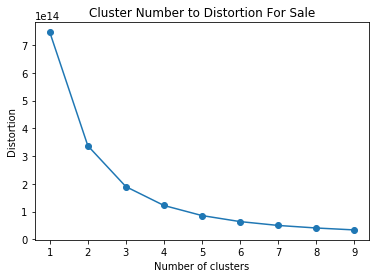

In [39]:
for_sale_res = run_k_mean(df_for_sale, 10, 'Cluster Number to Distortion For Sale')

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


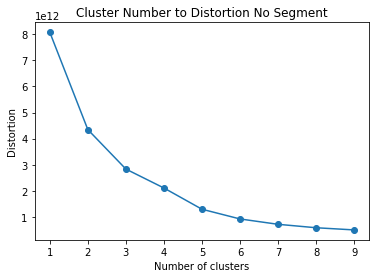

In [40]:
no_segment_res = run_k_mean(df_no_segment, 10, 'Cluster Number to Distortion No Segment')

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


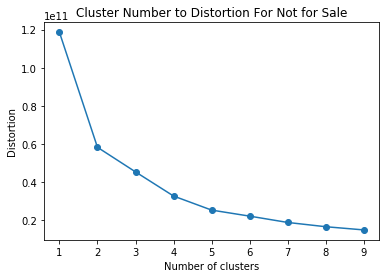

In [41]:
not_for_sale_res = run_k_mean(df_not_for_sale, 10, 'Cluster Number to Distortion For Not for Sale')

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


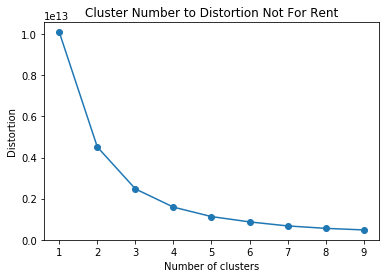

In [42]:
for_rent_res = run_k_mean(df_for_rent, 10, 'Cluster Number to Distortion Not For Rent')

In [47]:
normalized_for_sale_res_distortion = [i/max(for_sale_res[2]) for i in for_sale_res[2]]
print(normalized_for_sale_res_distortion)

[1.0, 0.4517411711973968, 0.25447326225121586, 0.16354458487928866, 0.11480447395058692, 0.08571744892608843, 0.06713475849185228, 0.05482363164450445, 0.045498377341104165]


In [48]:
normalized_no_segment_res_distortion = [i/max(no_segment_res[2]) for i in no_segment_res[2]]
print(normalized_no_segment_res_distortion)

[1.0, 0.5376597269102726, 0.3502360165701199, 0.2603580098068872, 0.15950717788258023, 0.1133607442552619, 0.08793062895859115, 0.07159725380925686, 0.06130582634869901]


In [51]:
normalized_not_for_sale_res_distortion = [i/max(not_for_sale_res[2]) for i in not_for_sale_res[2]]
print(normalized_not_for_sale_res_distortion)

[1.0, 0.4914447591401048, 0.38271046789948787, 0.27597583422786454, 0.21382521743122523, 0.1871258091189055, 0.15918201818673242, 0.1403271626152594, 0.12620102707893802]


In [52]:
normalized_for_rent_res_distortion = [i/max(for_rent_res[2]) for i in for_rent_res[2]]
print(normalized_for_rent_res_distortion)

[1.0, 0.4469832883553881, 0.24515845530724384, 0.1573817909620996, 0.11174546367335882, 0.0861908208341352, 0.0668489531933698, 0.05509335365832919, 0.047536889408844395]


## **Performance Summary of the Number of Clusters**

| Number of Clusters | For Sale Normalized Distortion | No Segment Normalized Distortion | Not For Sale Normalized Distortion | For Rent Normalized Distortion |
|------|------|------|------|------|
| 1  | 1 | 1 | 1 | 1 |
| 2  | 0.45 | 0.53 | 0.49  | 0.44 |
| 3  | 0.25 | 0.35 | 0.38 |  0.24 |
| 4  | 0.16 | 0.26 | 0.27 |  0.15 |
| 5  | 0.11 | 0.15 | 0.21 |  0.11 |
| | | | | |
| **6**  | **0.08** | **0.11** | **0.18** |  **0.08** |
| | | | | |
| 7  | 0.06 | 0.08 | 0.15 |  0.06 |
| 8  | 0.05 | 0.07 | 0.14 |  0.05 |
| 9  | 0.04 | 0.06 | 0.12 |  0.04 |

## Conclusions:
5 Clusters is a good number

## **More Insigth about the cluster = 5** 

In [12]:
# Initializing KMeans for 5 Clusters
kmeans = KMeans(n_clusters=5, 
                init='random',
                n_init=10, 
                max_iter=50,
                tol=1e-04, 
                random_state=0,
                n_jobs=multiprocessing.cpu_count()-2 )

In [13]:
# Fitting with inputs
kmeans = kmeans.fit(df_for_sale)

In [14]:
# Predicting the clusters
labels = kmeans.predict(df_for_sale)
# Getting the cluster centers
C = kmeans.cluster_centers_

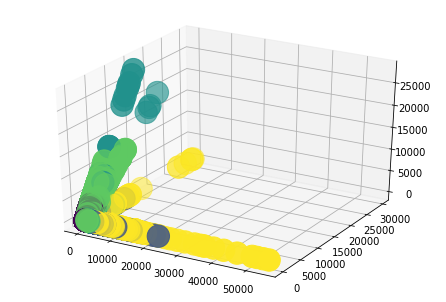

In [15]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(df_for_sale[df_for_sale.columns[0]], df_for_sale[df_for_sale.columns[3]], df_for_sale[df_for_sale.columns[5]], c=labels, s=500, cmap='viridis')
ax.scatter(C[:, 0], C[:, 3], C[:, 5], s=50, c='black', alpha=0.5)

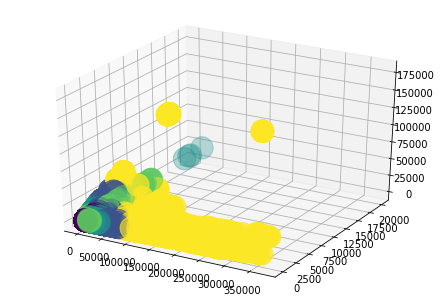

In [16]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(df_for_sale[df_for_sale.columns[4]], df_for_sale[df_for_sale.columns[6]], df_for_sale[df_for_sale.columns[7]], c=labels, s=500, cmap='viridis')
ax.scatter(C[:, 4], C[:, 6], C[:, 7], s=50, c='black', alpha=0.5)